In [1]:
from dataset import SolarPanelDataset
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import metrics
import training
import sklearn

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
data_path = Path("../data")
batch_size = 128
lr = 0.0001
epochs = 25
seed = 1048596
probs = [0.8, 0.1, 0.1]
num_workers = 8
epsilon = 1e-7
data_threshold = 0.005

chunk_size = 10

mode = "seg"

xlsx_path = data_path / "solar_panel_data_madagascar.xlsx"
img_path = data_path / "img"
weights_path = "/home/onyxia/work/StatApp/data/runs/InceptionV3_17:39:54_12-05-2025/model_23.pth"
tb_path = "/home/onyxia/work/StatApp/data/runs/InceptionV3_17:39:54_12-05-2025/events.out.tfevents.1747071594.vscode-pytorch-gpu-418391-0.85708.0"

torch.manual_seed(seed)

test_dataset = SolarPanelDataset(
    img_path, xlsx_path, "cls", "all", "test", probs, seed, data_threshold
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers,
    persistent_workers=True,
)

torch.set_float32_matmul_precision("high")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(weights_path, weights_only=False, map_location=device)
model = torch.compile(model).to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

def activation(x):
    return (torch.nn.functional.sigmoid(x) > prediction_threshold).long()


metrics_dict = {
    "F1": metrics.f1,
    "Accuracy": metrics.accuracy,
    "Precision": metrics.precision,
    "Recall": metrics.recall,
}

In [3]:
model.eval()

torch.set_grad_enabled(False)

test_pred = torch.Tensor([])
test_gt = torch.Tensor([])

for i, data in enumerate(tqdm(test_dataloader, position=0, leave=True)):
    img = data[0].to(device)
    test_gt = torch.cat((test_gt, data[1].squeeze().long()))
    target = data[1].squeeze().float().to(device)
    long_target = target.long()

    pred = model(img)
    pred = pred[:, 1]
    pred = pred.squeeze()
    test_pred = torch.cat((test_pred, torch.nn.functional.sigmoid(pred.to(torch.device("cpu")))))
    loss = loss_fn(pred, target)

test_pred = test_pred.numpy()
test_gt = test_gt.numpy()

  0%|          | 0/9 [00:00<?, ?it/s]

W0513 07:08:39.776000 3277 site-packages/torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode
100%|██████████| 9/9 [03:24<00:00, 22.73s/it] 


In [4]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}


In [5]:
scalars = ["Loss/train", "Loss/test"]
for metric in metrics_dict:
    scalars.append(f"{metric}/train")
    scalars.append(f"{metric}/test")
parsed_tensorboard = parse_tensorboard(tb_path, scalars)

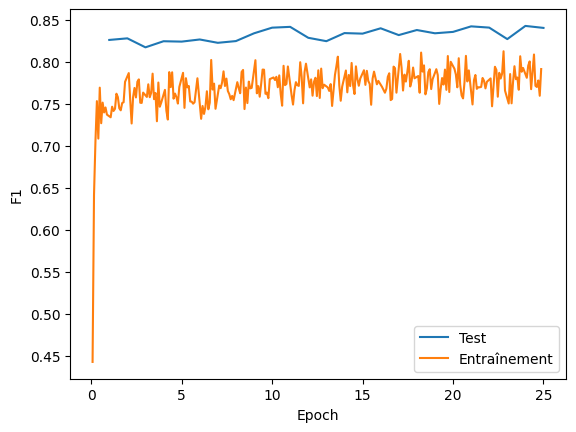

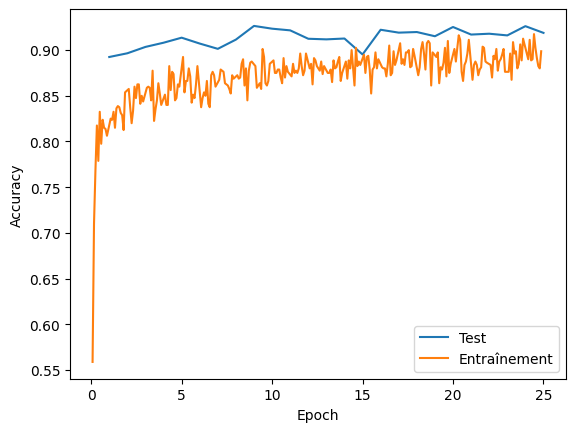

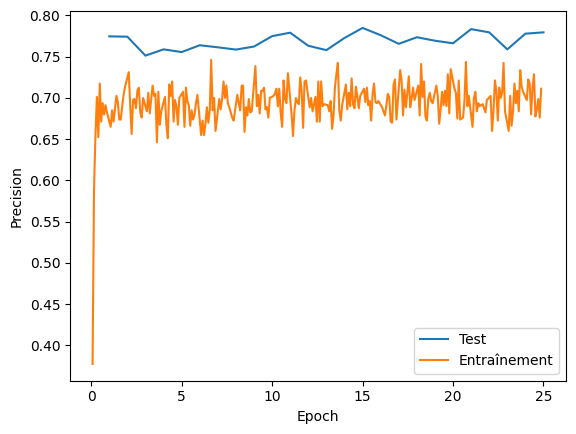

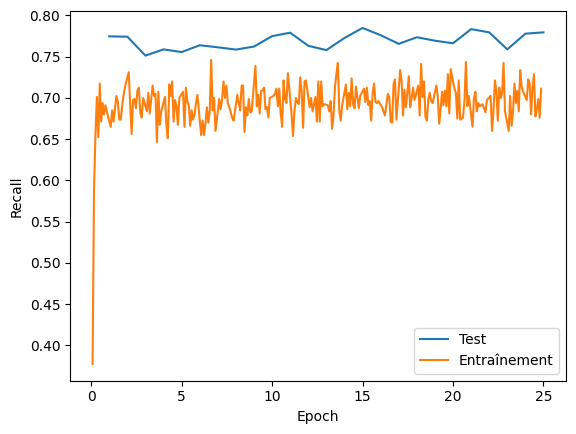

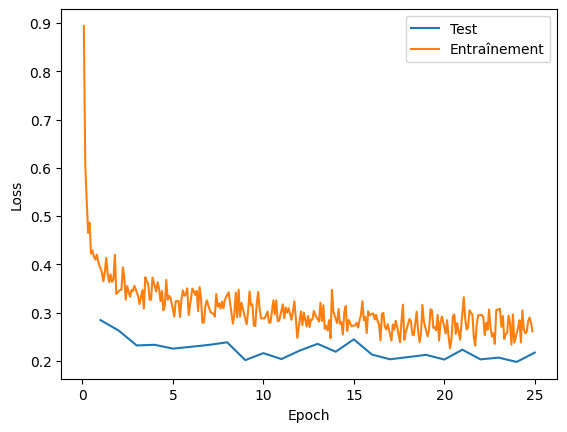

In [6]:
metrics_list = list(metrics_dict.keys()) + ["Loss"]
for metric in metrics_list:
    min_step = parsed_tensorboard[f"{metric}/test"]["step"].loc[0]
    plt.plot(parsed_tensorboard[f"{metric}/test"]["step"] / min_step, parsed_tensorboard[f"{metric}/test"]["value"], label="Test")
    plt.plot(parsed_tensorboard[f"{metric}/train"]["step"] / min_step, parsed_tensorboard[f"{metric}/train"]["value"], label="Entraînement")
    plt.ylabel(f"{metric}")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Text(0, 0.5, 'Taux de vrais positifs')

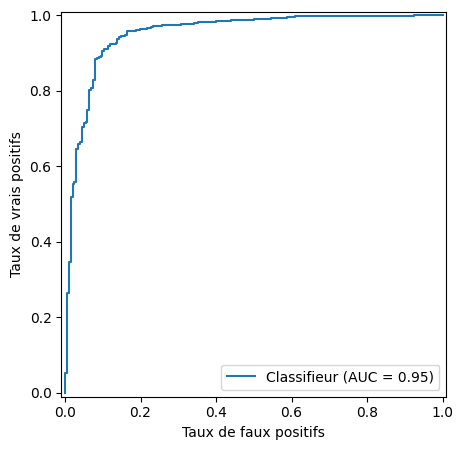

In [7]:
fig, axes = plt.subplots(figsize=(5, 5))
display = sklearn.metrics.RocCurveDisplay.from_predictions(test_gt, test_pred, name="Classifieur", ax=axes)
axes.set_xlabel("Taux de faux positifs")
axes.set_ylabel("Taux de vrais positifs")


In [8]:
test_bin_pred = test_pred > 0.5
print("F1:", sklearn.metrics.f1_score(test_gt, test_bin_pred))
print("Accuracy:", sklearn.metrics.accuracy_score(test_gt, test_bin_pred))
print("Recall:", sklearn.metrics.precision_score(test_gt, test_bin_pred))
print("Precision:", sklearn.metrics.recall_score(test_gt, test_bin_pred))

F1: 0.9576031656302996
Accuracy: 0.9304911955514366
Recall: 0.9495515695067265
Precision: 0.9657924743443558


Text(0, 0.5, 'Vraie étiquette')

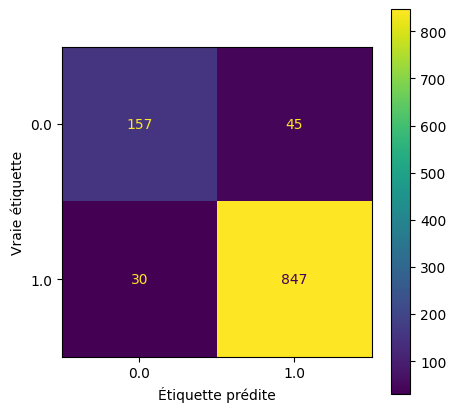

In [9]:
fig, axes = plt.subplots(figsize=(5, 5))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_gt, test_bin_pred, ax=axes)
axes.set_xlabel("Étiquette prédite")
axes.set_ylabel("Vraie étiquette")

In [10]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(test_gt, test_pred)
f1 = 2 * precision * recall / (precision + recall)
best_prediction_thredhold = f1.argmax()
print(f1.max())
print(thresholds[f1.argmax()], precision[f1.argmax()], recall[f1.argmax()])


0.9600450196961171
0.4513816 0.9477777777777778 0.9726339794754846


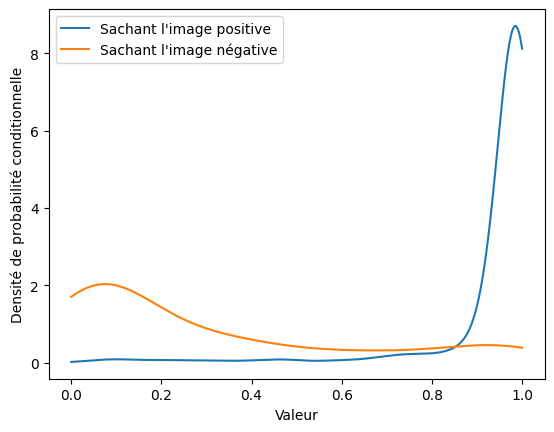

In [11]:
from scipy.stats import gaussian_kde

pos_data, neg_data = test_pred[test_gt == 1], test_pred[test_gt == 0]
pos_kde, neg_kde = gaussian_kde(pos_data), gaussian_kde(neg_data)
x = np.linspace(0, 1, 1000)
pos_pdf, neg_pdf = pos_kde(x), neg_kde(x)
plt.plot(x, pos_pdf, label="Sachant l'image positive")
plt.plot(x, neg_pdf, label="Sachant l'image négative")

plt.xlabel("Valeur")
plt.ylabel("Densité de probabilité conditionnelle")
plt.legend()
plt.show()

In [2]:
data_path = Path("../data")
batch_size = 16
lr = 0.0001
epochs = 25
seed = 1048596
probs = [0.8, 0.1, 0.1]
num_workers = 1
epsilon = 1e-7
data_threshold = 0.005

torch.manual_seed(seed)
torch.set_float32_matmul_precision("high")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = False

seg_weights_path = "/home/onyxia/work/StatApp/data/runs/DeepLabV3_16:02:31_09-05-2025/model_7.pth"
cls_weights_path = "/home/onyxia/work/StatApp/data/runs/InceptionV3_17:39:54_12-05-2025/model_23.pth"
xlsx_path = data_path / "solar_panel_data_madagascar.xlsx"
img_path = data_path / "img"

seg_model = torch.load(seg_weights_path, weights_only=False, map_location=device)
seg_model = torch.compile(seg_model).to(device)


cls_model = torch.load(cls_weights_path, weights_only=False, map_location=device)
cls_model = torch.compile(cls_model).to(device)

val_dataset = SolarPanelDataset(
    img_path, xlsx_path, "seg", "all", "val", probs, seed, data_threshold
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers,
    persistent_workers=True,
)

def activation(x):
    return (torch.nn.functional.sigmoid(x) > 0.5).long()

In [ ]:
cls_model.eval()
seg_model.eval()

torch.set_grad_enabled(False)
panels_count = 0
val_pred = torch.Tensor([])
val_gt = torch.Tensor([])

for i, data in enumerate(tqdm(val_dataloader, position=0, leave=True)):
    img = data[0].to(device)
    val_gt = torch.cat((val_gt, data[1].squeeze().long()))
    target = data[1].squeeze().float().to(device)
    pred = cls_model(img)
    pred = pred[:, 1]
    pred = pred.squeeze()
    bin_pred = activation(pred)
    
    img_to_segment = img[bin_pred == 1]
    segmented_img = activation(seg_model(img_to_segment)["out"].detach().squeeze()).float().to(torch.device("cpu"))
    panels_count += metrics.count_connected_components(segmented_img)
    predicted_masks = torch.zeros(target.shape)
    predicted_masks[bin_pred == 1] = segmented_img
    val_pred = torch.cat((val_pred, predicted_masks))

100%|██████████| 69/69 [18:43<00:00, 16.28s/it] 


In [28]:
print(metrics.jaccard(val_gt, val_pred))

tensor(0.5805)


In [4]:
true_panels_count = 0
for value in val_dataset.labels.values():
    true_panels_count += len(value)
print((true_panels_count - panels_count) / true_panels_count)

-0.09614340032590983
